# Setup
## Imports

In [1]:
import os
from os import environ
from os.path import join
import glob
from tqdm import tqdm

import geopandas as gpd
import pandas as pd
import numpy as np

import xarray as xr
import rioxarray

from pystac_client import Client
import planetary_computer as pc
import stackstac
from dask.diagnostics import ProgressBar

# Functions definition

In [2]:
# Functions

## Parameters

In [21]:
# main path
data_folder = '../data'

# paths
aoi_path = join(data_folder, 'admin', 'adm2.geojson')
modis_path = join(data_folder, 'modis', 'lst')

# start / end dates
start_date="2020-01-01"
end_date="2025-12-30"

# Main code
## Define the AOI

In [22]:
aoi_gdf = gpd.read_file(aoi_path)

aoi_utm_crs = aoi_gdf.estimate_utm_crs()
aoi_epsg_geom = aoi_gdf.to_crs(aoi_utm_crs).dissolve().buffer(1000).iloc[0]
bbox_4326 = aoi_gdf.to_crs(4326).unary_union.bounds # bounding box for search
bbox_epsg = aoi_gdf.to_crs(aoi_utm_crs).unary_union.bounds # to limit the downloaded data

## Search and download satellite images

In [4]:
# open the catalog
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace)

In [5]:
query = catalog.search(bbox=bbox_4326,
                        collections="modis-21A2-061",
                        datetime=f'{start_date}/{end_date}')
item_list = query.item_collection()

print(f"Found {len(item_list)} items")

Found 2577 items


In [ ]:
ds = stackstac.stack(
    item_list,
    assets=["LST_Day_1KM"],
    bounds=bbox_epsg,
    resolution=1000,
    rescale=False,
    xy_coords='center',
    epsg=aoi_utm_crs.to_epsg(),
    dtype='uint16',
    fill_value=0
)
with ProgressBar():
    ds.load()

/Users/pierre/.virtualenvs/masae-rs/lib/python3.9/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


[########################################] | 100% Completed | 175.88 s


In [18]:
# fix the time by parsing the id property
ds['time'] = (
    pd.to_datetime(ds['id'].str[9:13]) 
    + pd.to_timedelta(ds['id'].str[13:16].astype(int) - 1, unit='D')
)

# group by timestamp
ds = ds.groupby("time").max()
ds = ds.rio.write_nodata(0).astype('uint16')

In [19]:
# export all dates as tiffs
for i in tqdm(range(len(ds))):
    date = str(ds.isel(time=i)['time'].dt.strftime("%Y-%m-%d").data)
    export_name = date+'_LST_Day.tif'
    ds.isel(time=i).rename(date).rio.clip(
        [aoi_epsg_geom]).rio.to_raster(
        join(modis_path, export_name),
        compress="deflate",
        predictor=2
    )

100%|██████████| 248/248 [01:05<00:00,  3.77it/s]


## Perform zonal stats

In [37]:
from rasterio.enums import Resampling
from rasterstats import zonal_stats

file_list = glob.glob(os.path.join(modis_path, "*.tif"))

# define a model to reproject all the other rasters
df_list = []
for file in tqdm(file_list):
    date = pd.to_datetime(os.path.basename(file)[:10], yearfirst=True)

    # open the raster and extract
    with rioxarray.open_rasterio(file) as da:
        da = da.squeeze(dim='band')
        da = da.astype('float32').where(da != 0).rio.set_nodata(np.nan)
        da = da * 0.02 - 273.15 # to Celsius
        da = (da * 9/5) + 32 # to Fahrenheit
    
        # generate the zonal stats
        stats_dict = zonal_stats(
            aoi_gdf.to_crs(da.rio.crs),
            da.values,
            stats=['mean', 'max', 'min', 'std'],
            affine=da.rio.transform(),
            nodata=np.nan,
        )
        stats_df = pd.DataFrame(stats_dict)
        stats_df['month'] = date
        df_list.append(stats_df)

stats_df = pd.concat(df_list).join(aoi_gdf['district']).reset_index(drop=True)
stats_df = stats_df.sort_values(['month', 'district'])

100%|██████████| 248/248 [01:55<00:00,  2.14it/s]


In [38]:
# export
stats_df.to_csv(join(data_folder, 'indicators', 'temperature.csv'))

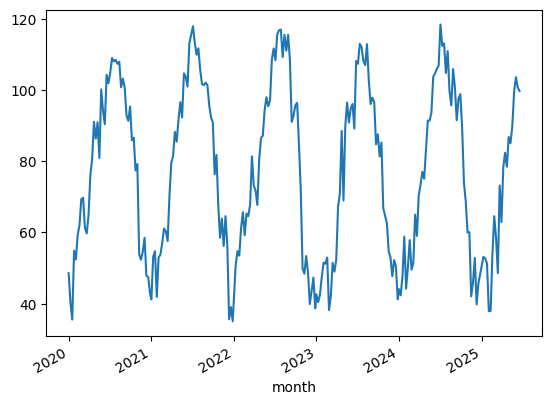

In [39]:
stats_df[stats_df['district']=='Northern Buttes District'].set_index('month')['mean'].plot();

## Generate yearly aggregation

In [43]:
modis_file_list = glob.glob(join(modis_path, '*.tif'))
years_list = ['2020', '2021', '2022', '2023', '2024', '2025']

df_list = []
for year in tqdm(years_list):
    export_file_tiff = join(data_folder, 'aggregates', f'temperature_{year}.tif')

    # if os.path.exists(export_file_tiff):
    #     continue

    file_list = sorted([f for f in modis_file_list if os.path.basename(f).startswith(str(year))])

    da_list = []
    # generate a rasters time series for the year
    for file in file_list:
        date = np.datetime64(os.path.basename(file)[:10])
               
        with rioxarray.open_rasterio(file) as da:
            da = da.squeeze(dim='band').drop_vars('band').expand_dims(time=[date])
            da = da.astype('float32').where(da != 0).rio.set_nodata(np.nan)
            da = da * 0.02 - 273.15 # to Celsius
            da = (da * 9/5) + 32 # to Fahrenheit
            da_list.append(da)
   
    ds_concat = xr.concat(da_list, dim='time').to_dataset(name='temperature')
    
    # generate cumulated tiff for the year
    ds_concat['temperature'].mean(dim='time').rio.set_nodata(np.nan).rio.to_raster(export_file_tiff, compress='deflate', predictor=2)

100%|██████████| 6/6 [00:11<00:00,  1.83s/it]
